# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from DSVC.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'DSVC/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


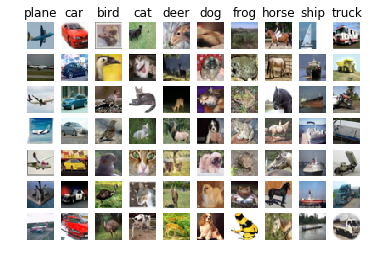

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) #np.flatnonzero可以得到非0元素位置
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


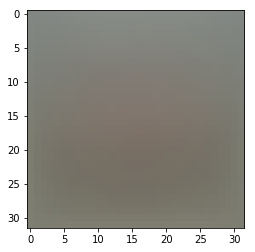

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

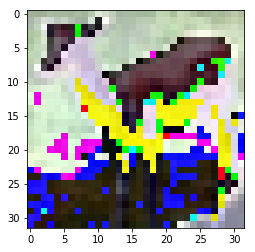

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image 
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image 

index_random = random.randint(0,X_train.shape[0])
plt.figure(figsize=(4,4))
plt.imshow(X_train[index_random].reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000L, 3073L) (1000L, 3073L) (1000L, 3073L) (500L, 3073L)


## SVM Classifier

Your code for this section will all be written inside **DSVC/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from DSVC.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
# W = np.random.randn(3073, 10) * 0.0001 
W = np.random.randn(10, 3073) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
# print(grad)
print('loss: %f' % (loss,))

loss: 9.177959


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from DSVC.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 42.123686 analytic: 42.123686, relative error: 6.520329e-13
numerical: 23.838204 analytic: 23.838204, relative error: 3.213354e-11
numerical: -4.829941 analytic: -4.829941, relative error: 1.166185e-11
numerical: -35.860805 analytic: -35.860805, relative error: 7.095856e-12
numerical: 1.085561 analytic: 1.085561, relative error: 1.007778e-10
numerical: 12.582942 analytic: 12.582942, relative error: 3.875103e-11
numerical: 20.687535 analytic: 20.687535, relative error: 2.121707e-11
numerical: -18.992275 analytic: -18.992275, relative error: 1.176492e-11
numerical: 14.935996 analytic: 14.935996, relative error: 4.436374e-12
numerical: 14.184263 analytic: 14.184263, relative error: 3.857017e-11
numerical: -0.987603 analytic: -0.992629, relative error: 2.538356e-03
numerical: 5.040471 analytic: 5.041981, relative error: 1.498051e-04
numerical: -16.086055 analytic: -16.067891, relative error: 5.649130e-04
numerical: 4.676870 analytic: 4.690388, relative error: 1.443066e-03
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:**

*我认为有两个方面:*

* 首先是Hinge Loss的锅（个人认为也是主要原因）:
Hinge Loss:
$$
f(x) = \max(0,x)
$$
可以看到该函数在0这个点是不可导的。我们代码里计算梯度也是让$margin>0$的才参与训练。但是用来比较的代码里则是通过为$x_i$加上和减去一个很小的值来求出结果，如下$gradient_1$，这里可能会出现$x_i$在通过$\omega$计算后的点原本是在0附近，通过加减值再与$\omega$相乘后变到了大于0或小于0的位置，这是原本不可求导的位置也变得能够根据$gradient_1$求出梯度，所以会出现误差

* 其次是学长写的用于检验梯度的值的求取方法是通过牛顿法求解的
$$
gradient_1 = \frac{f(x_2) - (fx_1)}{x_2-x_1}  \\    st. (x_{2}-x_{1})\to0
$$
然后我们用的虽然也是牛顿法的梯度计算公式：
$$
gradient_2 = \nabla f(x)
$$
但是$gradient_1$想要等于$gradient_2$必须满足$(x_{2}-x_{1})\to0$，这里学长是令$x_{2}-x_{1}=2e-5$，所以这里误差肯定是会有的


In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from DSVC.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.177959e+00 computed in 0.050000s
Vectorized loss: 9.177959e+00 computed in 0.077000s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.047000s
Vectorized loss and gradient: computed in 0.034000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from DSVC.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.319362
iteration 100 / 1500: loss 472.237841
iteration 200 / 1500: loss 285.654267
iteration 300 / 1500: loss 172.517883
iteration 400 / 1500: loss 106.843631
iteration 500 / 1500: loss 66.612391
iteration 600 / 1500: loss 41.917819
iteration 700 / 1500: loss 28.004216
iteration 800 / 1500: loss 18.576590
iteration 900 / 1500: loss 13.458229
iteration 1000 / 1500: loss 10.675093
iteration 1100 / 1500: loss 8.435820
iteration 1200 / 1500: loss 7.817068
iteration 1300 / 1500: loss 6.324165
iteration 1400 / 1500: loss 6.652806
That took 23.836000s


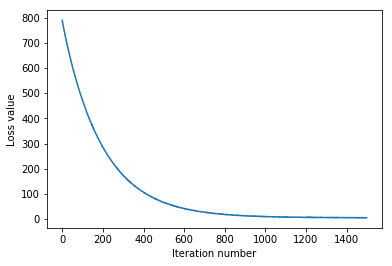

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
from mpl_toolkits.mplot3d import Axes3D
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.382959
validation accuracy: 0.387000


In [16]:

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7,2e-7,3e-7,4e-7]
regularization_strengths = [3e3,5e3,1e4,2.5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
accuracys = []
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
#                       num_iters=1500, everbose=True)
x_=[]
y_=[]
max_index = 0
index = 0
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        x_.append(learning_rate)
        y_.append(regularization_strength)
        svm_ = LinearSVM()
        svm_.train(X_train,y_train,learning_rate=learning_rate,reg=regularization_strength,
                 num_iters=3000,verbose=False)
        y_pred_val=svm_.predict(X_val)
        y_pred_train = svm_.predict(X_train)
        accuracy_val = np.mean(y_val == y_pred_val)
        accuracy_train = np.mean(y_train == y_pred_train)
        results[(learning_rate,regularization_strength)] = (accuracy_train,accuracy_val)
        #print("learning_rate=%e,reg=%e,accuracy=%f"%(learning_rate,regularization_strength,(accuracy_train+accuracy_val)/2))
        if (accuracy_val > np.array(accuracys)).all():
            best_svm = svm_
            best_val = accuracy_val
            max_index = index
        accuracys.append(accuracy_val)
        index+=1


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):  #排序
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-07 reg 3.000000e+03 train accuracy: 0.374959 val accuracy: 0.390000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.388245 val accuracy: 0.374000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.395286 val accuracy: 0.399000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.379571 val accuracy: 0.387000
lr 2.000000e-07 reg 3.000000e+03 train accuracy: 0.402449 val accuracy: 0.393000
lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.398286 val accuracy: 0.384000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 0.386449 val accuracy: 0.402000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.368408 val accuracy: 0.353000
lr 3.000000e-07 reg 3.000000e+03 train accuracy: 0.407265 val accuracy: 0.397000
lr 3.000000e-07 reg 5.000000e+03 train accuracy: 0.391408 val accuracy: 0.395000
lr 3.000000e-07 reg 1.000000e+04 train accuracy: 0.383469 val accuracy: 0.394000
lr 3.000000e-07 reg 2.500000e+04 train accuracy: 0.365061 val accuracy: 0.372000
lr 4.000000e-07 reg 3.000000

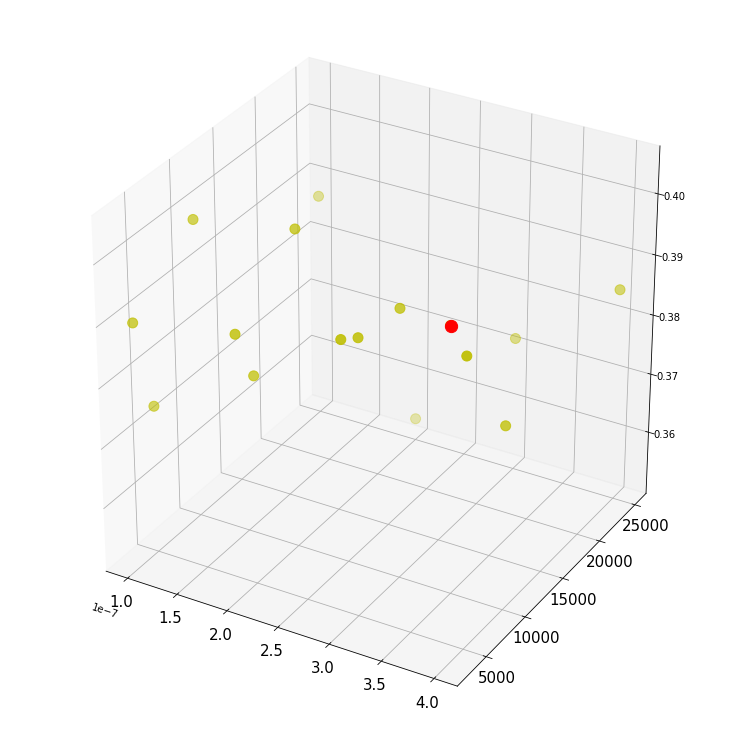

In [17]:
fig1=plt.figure(figsize=(10,10))

# ax = plt.subplot(111,projection='3d')
ax = Axes3D(fig1)
ax.scatter(x_,y_,accuracys,c="y",s=100)
ax.scatter(x_[max_index],y_[max_index],accuracys[max_index],c="r",s=150)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

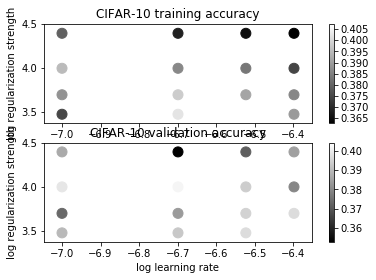

In [18]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.387000


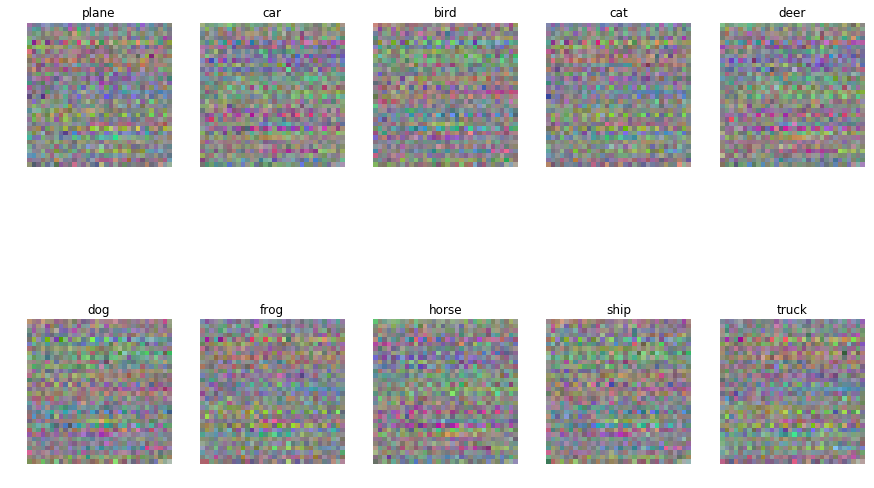

In [30]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

w = np.reshape(best_svm.W,(3073,10))
w = w[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(15,10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *仔细观察图像，发现图中的某些像素点组成了每种类别的一些轮廓，出现这种情况的原因：①物象分类更注重轮廓，因为同一物种它的具体信息千差万别，只有抽象信息是比较有代表性。②轮廓可能不那么明显是因为如果太明显则只能分类某一特定“姿势”的图像，我们加入了reg也是为了让这个轮廓看起来不那么明显，泛化性更好，不容易过拟合*